# Housing Price Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prices = pd.read_csv('../../data/Ames_Housing_Price_Data.csv',index_col = 0)
#estate = pd.read_csv('../../data/Ames_Real_Estate_Data.csv')

In [2]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 1 to 763
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2580 non-null   int64  
 1   GrLivArea      2580 non-null   int64  
 2   SalePrice      2580 non-null   int64  
 3   MSSubClass     2580 non-null   int64  
 4   MSZoning       2580 non-null   object 
 5   LotFrontage    2118 non-null   float64
 6   LotArea        2580 non-null   int64  
 7   Street         2580 non-null   object 
 8   Alley          168 non-null    object 
 9   LotShape       2580 non-null   object 
 10  LandContour    2580 non-null   object 
 11  Utilities      2580 non-null   object 
 12  LotConfig      2580 non-null   object 
 13  LandSlope      2580 non-null   object 
 14  Neighborhood   2580 non-null   object 
 15  Condition1     2580 non-null   object 
 16  Condition2     2580 non-null   object 
 17  BldgType       2580 non-null   object 
 18  HouseStyl

In [3]:
#Creating a price per square foot column to help with feature engineering
prices['Price_sqft'] = prices['SalePrice']/prices['GrLivArea']

# Converting quality/condition categoricals to numerical

In [4]:
def ordinal_scale(Series):
    return prices[Series].replace({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

prices['KitchenQual'] = ordinal_scale('KitchenQual')
prices['ExterQual'] = ordinal_scale('ExterQual')
prices['ExterCond'] = ordinal_scale('ExterCond')
prices['HeatingQC'] = ordinal_scale('HeatingQC')

In [5]:
def impute_ordinals(Series):
    '''
    Returns a pandas series containing null values and converting to numerical, ordered by median price per sqft.
    
    Args:
    

    Series: str, column name in the pandas dataframe.
    '''
    prices[Series].fillna('DNE',inplace = True)
    ords = prices.groupby(Series)['Price_sqft'].median().sort_values().reset_index()
    ords = list(ords[Series])
    impute = dict()
    for i, j in enumerate(ords):
        impute[j] = i
    prices[Series].replace(impute, inplace = True)
    return prices[Series]


In [6]:
impute_cols = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','FireplaceQu','GarageType','GarageFinish',
              'GarageQual','GarageCond','PoolQC','Fence']

for i in impute_cols:
    prices[i] = impute_ordinals(i)

In [7]:
prices[['Alley','BsmtQual','PoolQC','GarageFinish']].head()

,Alley,BsmtQual,PoolQC,GarageFinish
1,1,3,2,1
2,1,4,2,3
3,1,3,2,1
4,1,2,2,1
5,1,4,2,3


In [8]:
prices['MiscFeature'].fillna(0,inplace = True)
prices['MiscFeature'] = prices['MiscFeature'].apply(lambda M: 1 if M !=0 else M)
prices['CentralAir'].replace({'N':0,'Y':1},inplace = True)
prices['Street'].replace({'Grvl':1,'Pave':0},inplace = True)
prices['PavedDrive'].replace({'Y':1,'P':0.5,'N':0},inplace = True)
prices['Utilities'].replace({'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1},inplace = True)

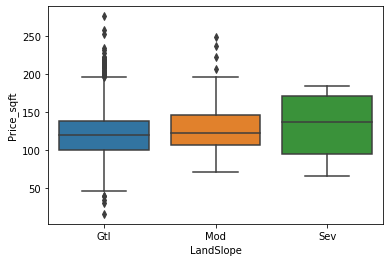

In [9]:
def cat_boxplots(Series):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.boxplot(data = prices, x = Series,y = 'Price_sqft')
    
cat_boxplots('LandSlope')

In [10]:
new_prices = prices.copy()
new_prices = new_prices.loc[~new_prices['Neighborhood'].isin(['Landmrk','Greens','GrnHill'])]

In [11]:
na_col = new_prices.isnull().sum()
na_col[na_col>0]

LotFrontage     458
MasVnrType       14
MasVnrArea       14
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     129
GarageCars        1
GarageArea        1
dtype: int64

In [12]:
def check_frontage(boro):
    x = prices['LotFrontage'].loc[prices['Neighborhood']==boro]
    return plt.hist(x)

(array([ 2.,  3.,  8., 30., 15., 14.,  9.,  5.,  2.,  2.]),
 array([ 40.,  48.,  56.,  64.,  72.,  80.,  88.,  96., 104., 112., 120.]),
 <BarContainer object of 10 artists>)

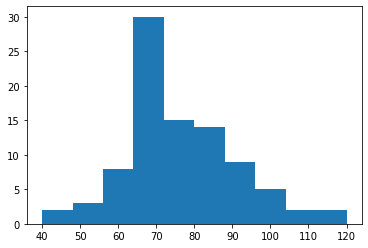

In [13]:
check_frontage('Sawyer')

## Reducing to numeric features

In [14]:
#impute lot frontage based off the mean of the respective neighborhood
new_prices['LotFrontage'] = new_prices['LotFrontage'].fillna(new_prices.groupby('Neighborhood')['LotFrontage'].transform('mean'))

In [15]:
len(new_prices.columns[prices.dtypes == object])

21

# Selecting numerical variables for multiple linear regression

In [16]:
numeric_features = new_prices.select_dtypes(include = np.number)
print(numeric_features.isnull().sum())

# imputing remaining numerical features with the mean
numeric_features_filled = numeric_features.apply(lambda x: x.fillna(x.mean()))
y_price = np.log(numeric_features_filled['SalePrice'])
numeric_features_filled.drop(['PID','SalePrice'], axis = 1, inplace = True)

PID            0
GrLivArea      0
SalePrice      0
MSSubClass     0
LotFrontage    0
              ..
MiscFeature    0
MiscVal        0
MoSold         0
YrSold         0
Price_sqft     0
Length: 61, dtype: int64


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features_filled.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features_filled.values, i) for i in range(len(numeric_features_filled.columns))]

/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [18]:
vifs = np.array(vif_data['VIF'])
bad_vifs = np.where(vifs>=5)


post_vifs = numeric_features_filled.drop(numeric_features_filled.columns[bad_vifs],axis = 1)

from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(post_vifs, y_price)

In [19]:
from sklearn.linear_model import LinearRegression
vif_reg = LinearRegression()
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

In [20]:
vif_reg.fit(Xtrain,ytrain)
vif_reg.score(Xtest,ytest)

0.5263642189725002

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

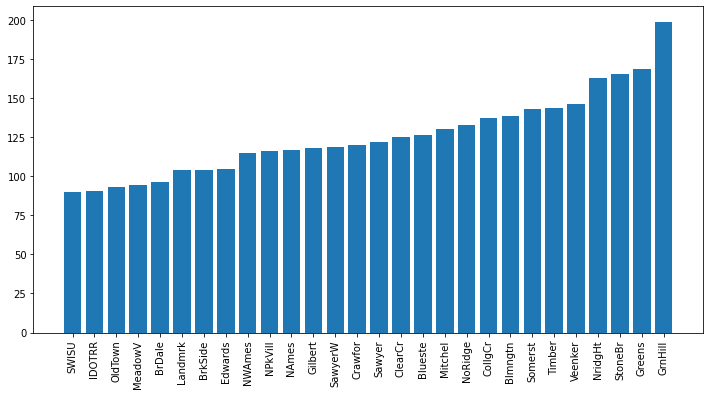

In [21]:
boro = prices.groupby('Neighborhood')[['Price_sqft']].mean()
boro = boro.reset_index().sort_values(by = 'Price_sqft')
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.bar(x = boro.Neighborhood, height = boro.Price_sqft)
plt.xticks(rotation = 90)

<AxesSubplot:>

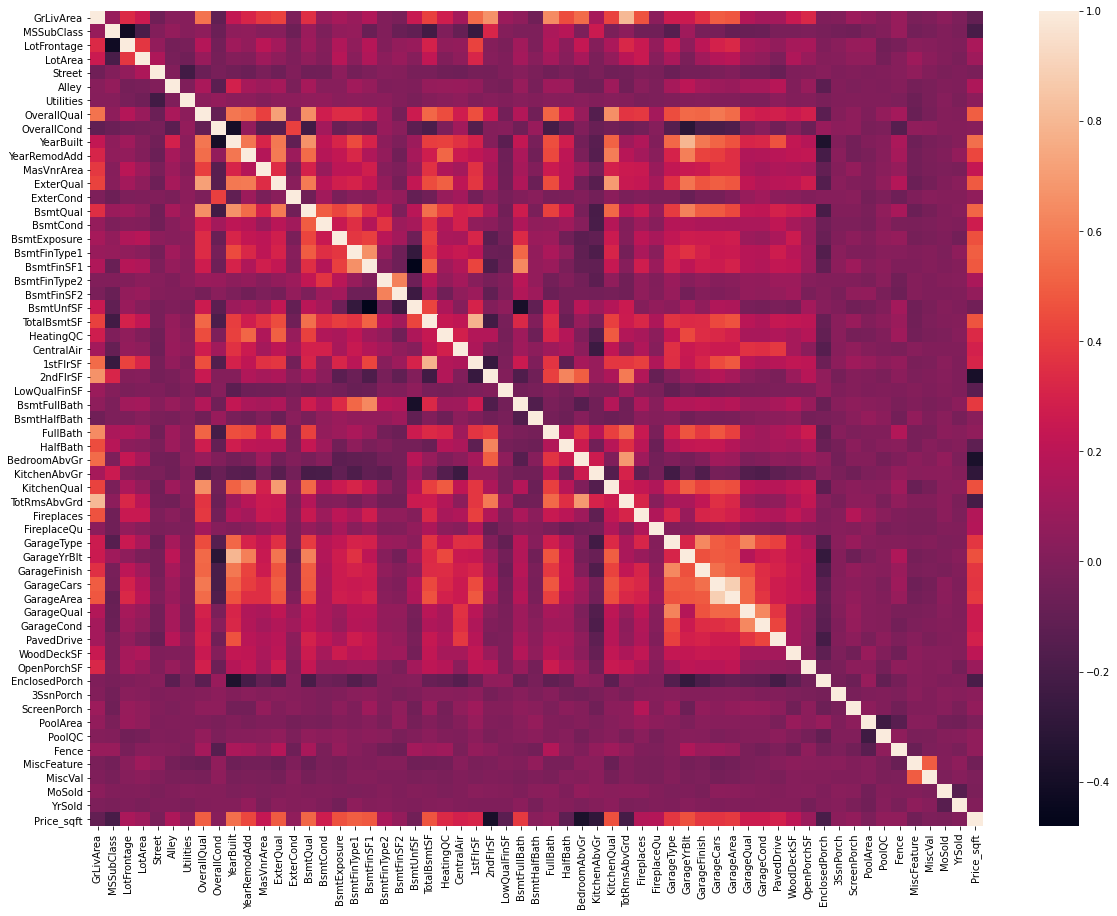

In [22]:
plt.figure(figsize = (20,15))
sns.heatmap(numeric_features_filled.corr())

In [23]:
r_prices = new_prices.corr()
r_prices = r_prices[['SalePrice']][1:]

<AxesSubplot:>

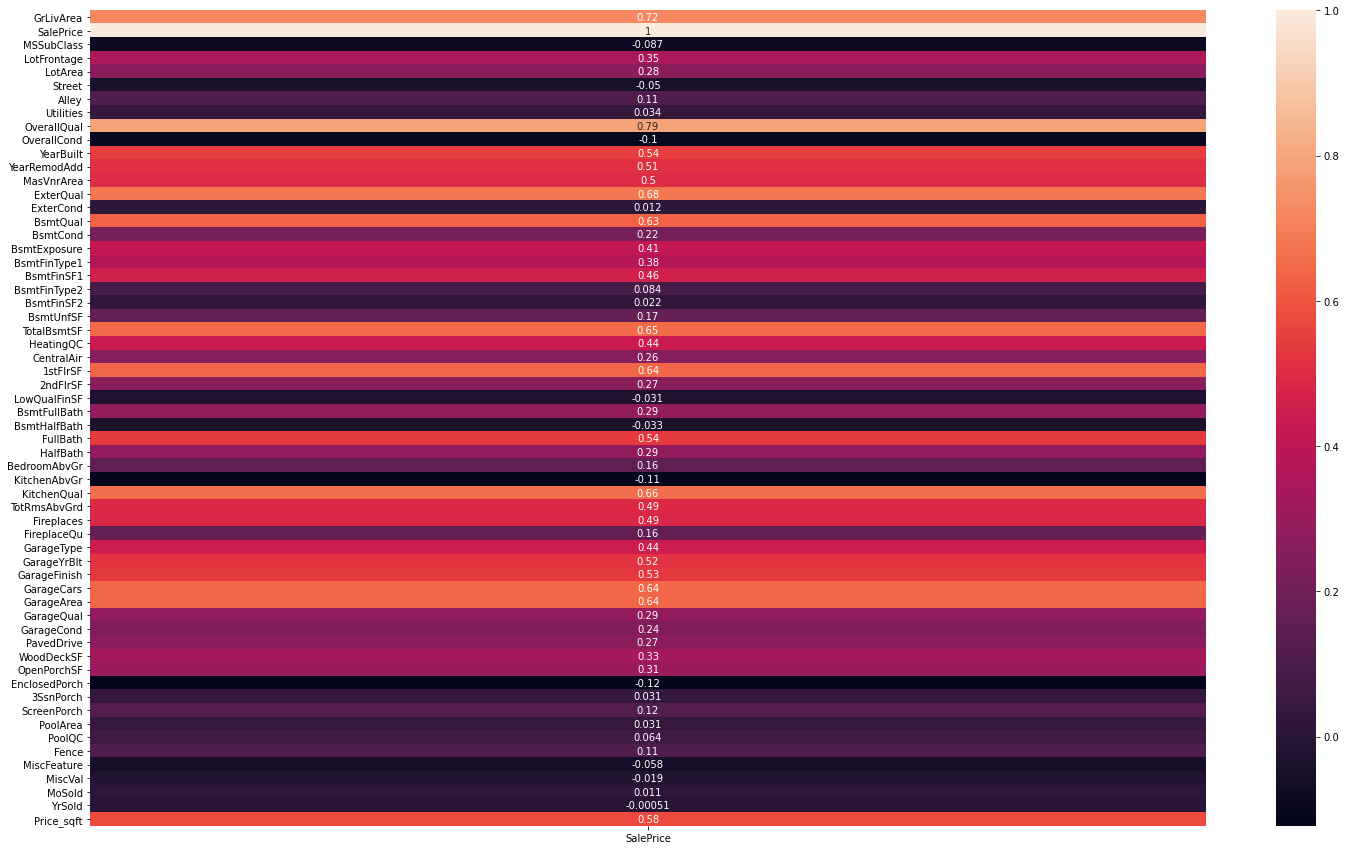

In [24]:
plt.figure(figsize = (25,15))
sns.heatmap(r_prices,annot = True)

In [25]:
numeric_features_filled.drop('Price_sqft',axis = 1, inplace = True)
numeric_features_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2569 entries, 1 to 763
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2569 non-null   int64  
 1   MSSubClass     2569 non-null   int64  
 2   LotFrontage    2569 non-null   float64
 3   LotArea        2569 non-null   int64  
 4   Street         2569 non-null   int64  
 5   Alley          2569 non-null   int64  
 6   Utilities      2569 non-null   int64  
 7   OverallQual    2569 non-null   int64  
 8   OverallCond    2569 non-null   int64  
 9   YearBuilt      2569 non-null   int64  
 10  YearRemodAdd   2569 non-null   int64  
 11  MasVnrArea     2569 non-null   float64
 12  ExterQual      2569 non-null   int64  
 13  ExterCond      2569 non-null   int64  
 14  BsmtQual       2569 non-null   int64  
 15  BsmtCond       2569 non-null   int64  
 16  BsmtExposure   2569 non-null   int64  
 17  BsmtFinType1   2569 non-null   int64  
 18  BsmtFinSF

In [26]:
prices.loc[prices.Electrical.isna()]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Price_sqft
626,916386080,1394,167500,80,RL,73.0,9735,0,1,Reg,...,0,2,3,0,0,5,2008,WD,Normal,120.157819


# Distribution of numerical variables

In [27]:
numeric_colnames = numeric_features_filled.columns
len(numeric_colnames)

58

<AxesSubplot:xlabel='OverallCond', ylabel='Count'>

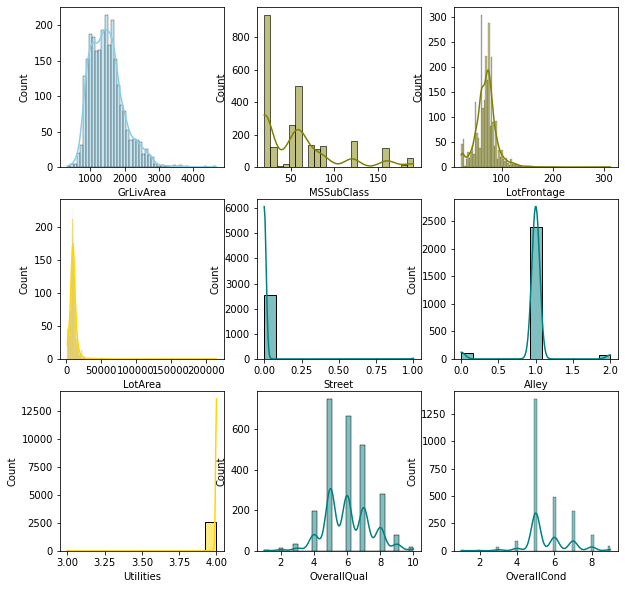

In [28]:
f, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.histplot( numeric_features_filled[numeric_colnames[0]] , color="skyblue", ax=axes[0, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[1]] , color="olive", ax=axes[0, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[2]], color="olive", ax=axes[0, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[3]], color="gold", ax=axes[1, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[4]], color="teal", ax=axes[1, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[5]], color="teal", ax=axes[1, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[6]], color="gold", ax=axes[2, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[7]], color="teal", ax=axes[2, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[8]], color="teal", ax=axes[2, 2],kde= True)

<AxesSubplot:xlabel='BsmtFinType1', ylabel='Count'>

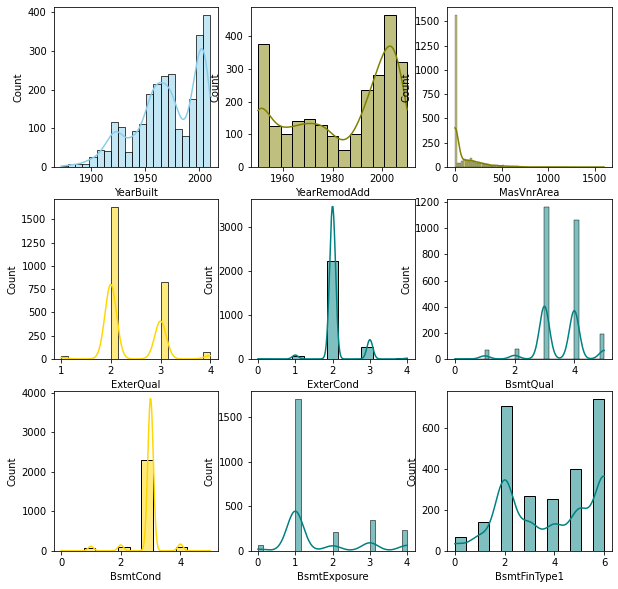

In [29]:
f, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.histplot( numeric_features_filled[numeric_colnames[9]] , color="skyblue", ax=axes[0, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[10]] , color="olive", ax=axes[0, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[11]], color="olive", ax=axes[0, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[12]], color="gold", ax=axes[1, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[13]], color="teal", ax=axes[1, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[14]], color="teal", ax=axes[1, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[15]], color="gold", ax=axes[2, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[16]], color="teal", ax=axes[2, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[17]], color="teal", ax=axes[2, 2],kde= True)

<AxesSubplot:xlabel='2ndFlrSF', ylabel='Count'>

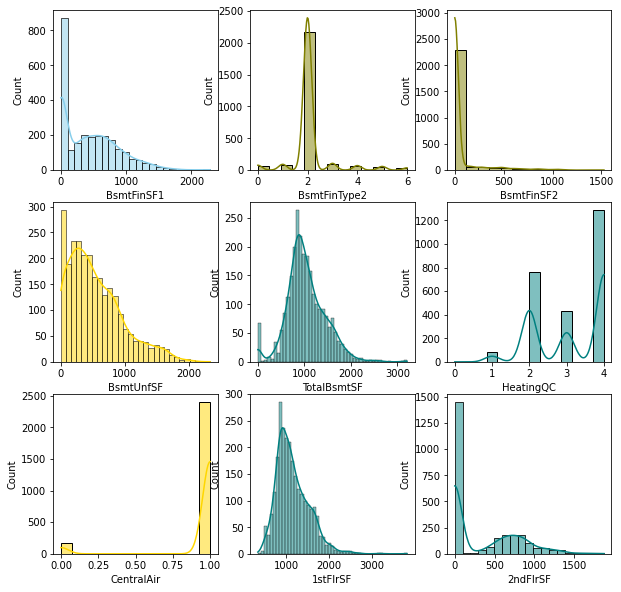

In [30]:
f, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.histplot( numeric_features_filled[numeric_colnames[18]] , color="skyblue", ax=axes[0, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[19]] , color="olive", ax=axes[0, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[20]], color="olive", ax=axes[0, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[21]], color="gold", ax=axes[1, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[22]], color="teal", ax=axes[1, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[23]], color="teal", ax=axes[1, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[24]], color="gold", ax=axes[2, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[25]], color="teal", ax=axes[2, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[26]], color="teal", ax=axes[2, 2],kde= True)

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='Count'>

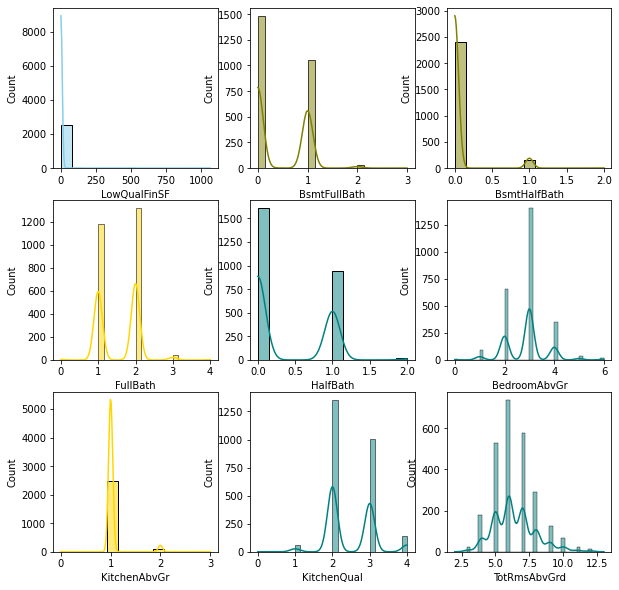

In [31]:
f, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.histplot( numeric_features_filled[numeric_colnames[27]] , color="skyblue", ax=axes[0, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[28]] , color="olive", ax=axes[0, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[29]], color="olive", ax=axes[0, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[30]], color="gold", ax=axes[1, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[31]], color="teal", ax=axes[1, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[32]], color="teal", ax=axes[1, 2],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[33]], color="gold", ax=axes[2, 0],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[34]], color="teal", ax=axes[2, 1],kde= True)
sns.histplot( numeric_features_filled[numeric_colnames[35]], color="teal", ax=axes[2, 2],kde= True)

Median is 159900.0
Mean is 178059.62325581396


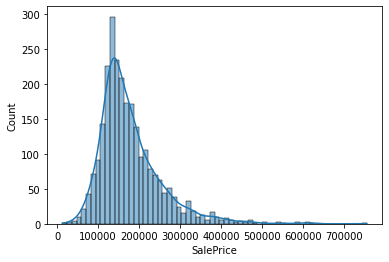

In [32]:
sns.histplot(new_prices.SalePrice,kde = True)
print(f'Median is {np.median(prices.SalePrice)}')
print(f'Mean is {np.mean(prices.SalePrice)}')

### Five fold CV using KFold

<p> Gabi says drop garagecars, garagequal and garagecondition</p>

In [33]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso


Xtrain,Xtest,ytrain,ytest = train_test_split(numeric_features_filled,y_price)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
cv = KFold(n_splits = 5, shuffle = True)


from sklearn.linear_model import Lasso
lasso = Lasso(max_iter = 3500000)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
pipe = Pipeline(steps = [('ss',StandardScaler()),('lasso',lasso)])

alphas = np.linspace(.0001,10,500)

cv_res=[]

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    pipe = Pipeline(steps = [('ss',StandardScaler()),('lasso',lasso)])
    cv_res.append(cross_validate(pipe, Xtrain,ytrain,cv = cv, return_train_score = True))

In [34]:
cv_res

[{'fit_time': array([0.02934599, 0.02706289, 0.02485919, 0.0232048 , 0.02498198]),
  'score_time': array([0.00215793, 0.00150204, 0.0012517 , 0.00122905, 0.00122595]),
  'test_score': array([0.91470247, 0.8959302 , 0.88683584, 0.87472624, 0.91490656]),
  'train_score': array([0.90210483, 0.90668277, 0.90891279, 0.91136723, 0.90216233])},
 {'fit_time': array([0.00457716, 0.00460219, 0.00454307, 0.00452805, 0.0045259 ]),
  'score_time': array([0.00121284, 0.00121498, 0.00120401, 0.00120783, 0.00120521]),
  'test_score': array([0.90563282, 0.87783582, 0.8167315 , 0.90588997, 0.89733679]),
  'train_score': array([0.88040113, 0.88540133, 0.90041616, 0.87939749, 0.8778383 ])},
 {'fit_time': array([0.00440812, 0.00433421, 0.00436997, 0.00425911, 0.00428128]),
  'score_time': array([0.00120497, 0.00120974, 0.00119901, 0.00120783, 0.00120378]),
  'test_score': array([0.81692851, 0.86870637, 0.84659475, 0.8223759 , 0.85894147]),
  'train_score': array([0.85835768, 0.8426637 , 0.84284622, 0.85472

In [35]:
# cv = KFold(n_splits = 5, shuffle = True)


# from sklearn.linear_model import Lasso
# lasso = Lasso(max_iter = 3500000)


# from sklearn.model_selection import cross_validate
# alphas = np.linspace(.0001,10,500)

# cv_res=[]

# for alpha in alphas:
#     lasso.set_params(alpha = alpha)
#     cv_res.append(cross_validate(lasso, Xtrain, ytrain, cv = cv, return_train_score = True))

In [36]:
lasso_test = [i['test_score'].mean() for i in cv_res]
lasso_train = [i['train_score'].mean() for i in cv_res]

In [37]:
alpha_ind = lasso_test.index(max(lasso_test))
f'alpha: {alphas[alpha_ind]}, train_score: {lasso_train[alpha_ind]}, test_score: {lasso_test[alpha_ind]}'

'alpha: 0.0001, train_score: 0.9062459923019024, test_score: 0.89742025887594'

In [38]:
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
lasso = Lasso()
lasso.set_params(alpha = alphas[alpha_ind])
lasso.fit(Xtrain,ytrain)

lasso_train_results = lasso.score(Xtrain,ytrain)
lasso_test_results = lasso.score(Xtest,ytest)
print(lasso_train_results)
print(lasso_test_results)

0.9054149302896738
0.9141091424151842


In [39]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtrain,ytrain)

print(f'Lasso training score: {lasso_train_results}')
print(f'Lasso testing score: {lasso_test_results}')
print(f'MLR training score: {ols.score(Xtrain,ytrain)}')
print(f'MLR testing score: {ols.score(Xtest,ytest)}')

from sklearn.metrics import mean_squared_error
y_pred = ols.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred)**0.5
print(f'RMSE: {RMSE}')

Lasso training score: 0.9054149302896738
Lasso testing score: 0.9141091424151842
MLR training score: 0.9053548396871743
MLR testing score: 0.913547047257283
RMSE: 0.10960681459063332


In [40]:
coefs = lasso.coef_
zero_idx = np.where(coefs == 0)
numeric_features_filled.columns[zero_idx]

Index(['BsmtUnfSF', '2ndFlrSF'], dtype='object')

In [41]:
for col, coef in zip(numeric_features_filled.columns, lasso.coef_):
    print(f'{col}:   {coef}')

GrLivArea:   0.12004562893345734
MSSubClass:   -0.02068517909319959
LotFrontage:   0.009834709234743918
LotArea:   0.02015274779380968
Street:   0.0002573425864399168
Alley:   0.004669655549709063
Utilities:   0.004766369575683153
OverallQual:   0.09285577778362376
OverallCond:   0.05823815512212262
YearBuilt:   0.06324564111778272
YearRemodAdd:   0.005082631162287797
MasVnrArea:   -0.0018423692682860446
ExterQual:   0.011838824045396025
ExterCond:   -0.005482649249320998
BsmtQual:   0.014394407628053451
BsmtCond:   -0.0036098259227358223
BsmtExposure:   0.013678445421932535
BsmtFinType1:   0.010161678067494581
BsmtFinSF1:   0.02277998905033594
BsmtFinType2:   -0.003907824933340516
BsmtFinSF2:   0.009422456186196316
BsmtUnfSF:   -0.0
TotalBsmtSF:   0.035259325548543226
HeatingQC:   0.02069715398250854
CentralAir:   0.01372236292523392
1stFlrSF:   0.006454034444151785
2ndFlrSF:   0.0
LowQualFinSF:   -0.007143738026849207
BsmtFullBath:   0.011033149230253328
BsmtHalfBath:   0.00106941150

# Drop Features Post-lasso

In [42]:
post_lasso = numeric_features_filled.drop(numeric_features_filled.columns[zero_idx],axis = 1)

In [43]:
Xtrain,Xtest,ytrain,ytest = train_test_split(post_lasso,y_price)

Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)


ols2 = LinearRegression()
ols2.fit(Xtrain,ytrain)

LinearRegression()

In [44]:
print(f'Post-lasso training score: {ols2.score(Xtrain,ytrain)}')
print(f'Post-lasso testing score: {ols2.score(Xtest,ytest)}')

y_pred = ols2.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred)**0.5
print(f'Post-lasso RMSE: {RMSE}')

Post-lasso training score: 0.9066299032706167
Post-lasso testing score: 0.9123898681751476
Post-lasso RMSE: 0.11267438161426248


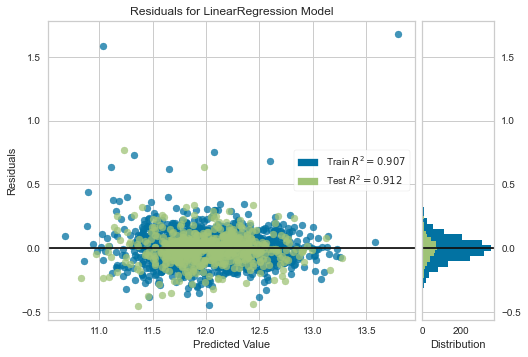

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [45]:
from yellowbrick.regressor import ResidualsPlot
ols2 = LinearRegression()
visualizer = ResidualsPlot(ols2)
visualizer.fit(Xtrain, ytrain) 
visualizer.score(Xtest, ytest)  
visualizer.show() 

In [46]:
print(len(prices.columns))
print(len(numeric_features_filled.columns))

82
58


## Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gBoost = GradientBoostingRegressor()

In [48]:
gBoost.fit(Xtrain,ytrain)
print(gBoost.score(Xtrain,ytrain))
print(gBoost.score(Xtest,ytest))

y_pred = gBoost.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred)**0.5
print(f'Gradient Boosting RMSE: {RMSE}')

0.9558755146779866
0.9037093585133854
Gradient Boosting RMSE: 0.11812451987883132


<p>After selecting features with lasso, Linear regression R2 was .91, while a default GradientBoostingRegressor yielded .905</p>